In [ ]:
import pandas as pd
import pydot, pydotplus, graphviz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras.constraints import non_neg
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

%matplotlib inline

#### Train subset

In [517]:
dataset_ = pd.read_csv("/Users/ilonakulikovskikh/code/data/idg_ilona/case2/case2_train.csv",sep=',')

In [518]:
print(dataset_.head())
dataset = dataset_[['cmpd_id','target_id','pKd']]
print(dataset.head())

   Unnamed: 0        cmpd_id target_id       pKd  CHEMBL360138  CHEMBL3091726  \
0           1  CHEMBL1232461    P25440  7.000000      0.616438       0.611765   
1           2  CHEMBL1232461    O60885  7.187087      0.616438       0.611765   
2          10  CHEMBL3645119    P52333  8.537602      0.481481       0.579545   
3          11  CHEMBL3645119    P43405  7.008774      0.481481       0.579545   
4          13  CHEMBL3645119    P23458  8.173925      0.481481       0.579545   

   CHEMBL584293  CHEMBL3605998  CHEMBL2435408  CHEMBL3752448   ...    P07306  \
0      0.500000       0.520000       0.493506       0.548780   ...     0.101   
1      0.500000       0.520000       0.493506       0.548780   ...     0.026   
2      0.609195       0.657143       0.602740       0.767123   ...     0.097   
3      0.609195       0.657143       0.602740       0.767123   ...     0.126   
4      0.609195       0.657143       0.602740       0.767123   ...     0.088   

   Q9Z1T6  P01127  P19838  Q96A5

In [519]:
n_cmpds = len(dataset.cmpd_id.unique())
n_targets = len(dataset.target_id.unique())
len(dataset.cmpd_id.unique()), len(dataset.target_id.unique())

(789, 442)

In [520]:
dataset.cmpd_id = dataset.cmpd_id.astype('category').cat.codes.values
dataset.target_id = dataset.target_id.astype('category').cat.codes.values

In [521]:
# Get summary statistics
dataset['pKd'].describe()

count    13786.000000
mean         5.506083
std          0.989398
min          1.806875
25%          5.000000
50%          5.000000
75%          5.698970
max         12.602060
Name: pKd, dtype: float64

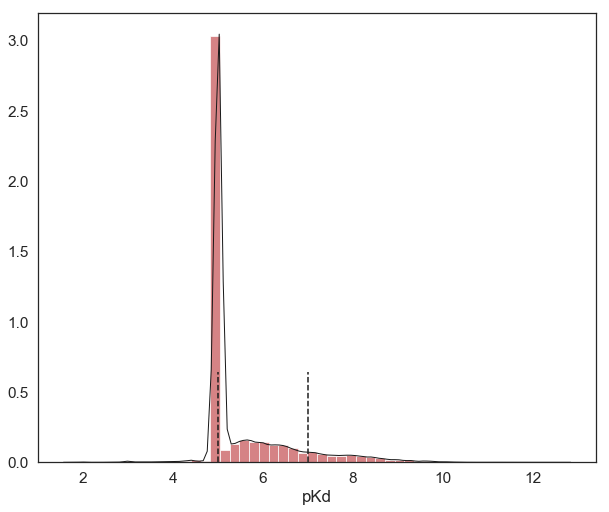

In [522]:

sns.set(rc={'figure.figsize':(10,8.27)})

sns.set_color_codes()
sns.set(style='white', font_scale=1.4)


# Display distribution 
sns.distplot(dataset['pKd'].fillna(dataset['pKd'].median()),
            kde_kws={"color": "k", "lw": 1},
            hist_kws={"alpha": 0.7, "color": "r"})
plt.axvline(7, 0, 0.2, color="k", linestyle="--")
plt.axvline(5, 0, 0.2, color="k", linestyle="--")

#### Validation subset

   Unnamed: 0        cmpd_id target_id       pKd  CHEMBL360138  CHEMBL3091726  \
0           4  CHEMBL3669127    P63085  5.031517      0.518987       0.654762   
1           5  CHEMBL3669127    P47811  5.346787      0.518987       0.654762   
2           6  CHEMBL2386796    Q9UM73  8.619789      0.625000       0.536082   
3           7  CHEMBL3605998    P11103  7.522879      0.440000       0.607595   
4           8  CHEMBL3669571    O43614  6.818156      0.460526       0.604938   

   CHEMBL584293  CHEMBL3605998  CHEMBL2435408  CHEMBL3752448   ...    P07306  \
0      0.538462       0.567568       0.560000       0.573171   ...     0.210   
1      0.538462       0.567568       0.560000       0.573171   ...     0.017   
2      0.785714       0.575000       0.567901       0.674699   ...     0.061   
3      0.560976       1.000000       0.750000       0.671429   ...     0.108   
4      0.578313       0.754098       0.963636       0.643836   ...     0.087   

   Q9Z1T6  P01127  P19838  Q96A5

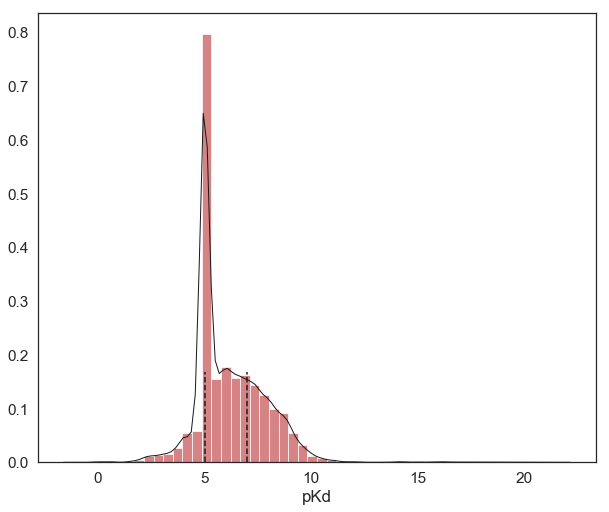

In [576]:
dataset__ = pd.read_csv("/Users/ilonakulikovskikh/code/data/idg_ilona/case2/case2_validation.csv",sep=',')

print(dataset__.head())
dataset_val = dataset__[['cmpd_id','target_id','pKd']]
print(dataset_val.head())

n_cmpds_val = len(dataset_val.cmpd_id.unique())
n_targets_val = len(dataset_val.target_id.unique())
print(len(dataset_val.cmpd_id.unique()), len(dataset_val.target_id.unique()))

dataset_val.cmpd_id = dataset_val.cmpd_id.astype('category').cat.codes.values
dataset_val.target_id = dataset_val.target_id.astype('category').cat.codes.values

dataset_val.cmpd_id = dataset_val.cmpd_id.astype('category').cat.codes.values
dataset_val.target_id = dataset_val.target_id.astype('category').cat.codes.values

# Get summary statistics
dataset_val['pKd'].describe()


sns.set(rc={'figure.figsize':(10,8.27)})

sns.set_color_codes()
sns.set(style='white', font_scale=1.4)


# Display distribution 
sns.distplot(dataset_val['pKd'].fillna(dataset_val['pKd'].median()),
            kde_kws={"color": "k", "lw": 1},
            hist_kws={"alpha": 0.7, "color": "r"})
plt.axvline(7, 0, 0.2, color="k", linestyle="--")
plt.axvline(5, 0, 0.2, color="k", linestyle="--")

## Approach 1: Memory-based CF     --Similarity

In [632]:
# Fill NaN values in cmpd_id and target_id column with 0
dataset['cmpd_id'] = dataset['cmpd_id'].fillna(0)
dataset['target_id'] = dataset['target_id'].fillna(0)

# Replace NaN values in rating column with average of all values
dataset['pKd'] = dataset['pKd'].fillna(dataset['pKd'].mean())

# Fill NaN values in cmpd_id and target_id column with 0
dataset_val['cmpd_id'] = dataset_val['cmpd_id'].fillna(0)
dataset_val['target_id'] = dataset_val['target_id'].fillna(0)

# Replace NaN values in rating column with average of all values
dataset_val['pKd'] = dataset_val['pKd'].fillna(dataset_val['pKd'].mean())

#### Subset of the full dataset

In [614]:

# Check the samples info
print(dataset.info())
print(dataset_val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13786 entries, 0 to 13785
Data columns (total 3 columns):
cmpd_id      13786 non-null int16
target_id    13786 non-null int16
pKd          13786 non-null float64
dtypes: float64(1), int16(2)
memory usage: 161.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40159 entries, 0 to 40158
Data columns (total 3 columns):
cmpd_id      40159 non-null int16
target_id    40159 non-null int16
pKd          40159 non-null float64
dtypes: float64(1), int16(2)
memory usage: 470.7 KB
None


In [624]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = dataset.as_matrix(columns = ['cmpd_id', 'target_id', 'pKd'])
val_data_matrix = dataset_val.as_matrix(columns = ['cmpd_id', 'target_id', 'pKd'])

# Check their shape
print(train_data_matrix.shape)
print(val_data_matrix.shape)

(13786, 3)
(40159, 3)


In [625]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
cmpd_correlation = 1 - pairwise_distances(train_data_matrix, metric='correlation')
cmpd_correlation[np.isnan(cmpd_correlation)] = 0
print(cmpd_correlation[:5, :5])

[[ 1.          0.84452484 -0.04750078 -0.10282281 -0.18771635]
 [ 0.84452484  1.          0.4947963   0.44584155  0.36746552]
 [-0.04750078  0.4947963   1.          0.99846104  0.99003122]
 [-0.10282281  0.44584155  0.99846104  1.          0.99631871]
 [-0.18771635  0.36746552  0.99003122  0.99631871  1.        ]]


In [626]:
# Item Similarity Matrix
target_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
target_correlation[np.isnan(target_correlation)] = 0
print(target_correlation[:5, :5])

[[ 1.          0.00878996  0.03367074]
 [ 0.00878996  1.         -0.1141953 ]
 [ 0.03367074 -0.1141953   1.        ]]


In [630]:
# Function to predict ratings
def predict(dataset_any, similarity, type='cmpd'):
    if type == 'cmpd':
        mean_cmpd_rating = dataset_any.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (dataset_any - mean_cmpd_rating[:, np.newaxis])
        pred = mean_cmpd_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'target':
        pred = dataset_any.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [654]:
print(cmpd_correlation.shape)
print(target_correlation.shape)

(13786, 13786)
(3, 3)


In [655]:
# Predict ratings on the training data with both similarity score
cmpd_prediction = predict(train_data_matrix, cmpd_correlation, type='cmpd')
target_prediction = predict(train_data_matrix, target_correlation, type='target')

# RMSE on the test data
#print('Cmpd-based CF RMSE: ' + str(rmse(cmpd_prediction, val_data_matrix[0:10])))
#print('Target-based CF RMSE: ' + str(rmse(target_prediction, val_data_matrix)))

In [656]:
print(cmpd_prediction.shape)
print(target_prediction.shape)
print(val_data_matrix.shape)
print(train_data_matrix.shape)

(13786, 3)
(13786, 3)
(40159, 3)
(13786, 3)


In [606]:
# Predict ratings on the training data with both similarity score
cmpd_prediction = predict(train_data_matrix, cmpd_correlation, type='cmpd')
target_prediction = predict(train_data_matrix, target_correlation, type='target')


# RMSE on the train data
print('Cmpd-based CF RMSE: ' + str(rmse(cmpd_prediction, train_data_matrix)))
print('Target-based CF RMSE: ' + str(rmse(target_prediction, train_data_matrix)))

Cmpd-based CF RMSE: 91.78605777724194
Target-based CF RMSE: 21.586766447549152


## Approach 2: Model-based CF     --MF with SVD

In [540]:
interactions = dataset.pivot(index = 'cmpd_id', columns ='target_id', values = 'pKd').fillna(0)
interactions.head()

target_id,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,441
cmpd_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,5.481486,0.0,5.0,5.0,0.0,5.0,0.0,...,5.0,5.0,0.0,5.0,5.568636,5.0,5.0,0.0,5.0,5.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,5.000000,5.0,5.0,5.0,0.0,5.0,0.0,...,5.0,5.0,0.0,5.0,5.000000,5.0,5.0,0.0,5.0,5.0
3,0.0,0.0,0.0,5.000000,5.0,5.0,5.0,0.0,5.0,0.0,...,5.0,5.0,0.0,5.0,6.040959,5.0,5.0,0.0,5.0,5.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [541]:
R = dataset.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
interactions_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [542]:
sparsity = round(1.0 - len(dataset) / float(n_cmpds * n_targets), 3)
print ('The sparsity level of dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of dataset is 96.0%


In [543]:
## from scipy.sparse.linalg import svds
print(interactions_demeaned.shape)
U, sigma, Vt = svds(interactions_demeaned, k = 2)

(13786, 3)


In [544]:
sigma = np.diag(sigma)

In [545]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [546]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = dataset.columns)
preds.head()

,cmpd_id,target_id,pKd
0,25.0,122.0,7.000000
1,25.0,34.0,7.187087
2,561.0,191.0,8.537602
3,561.0,162.0,7.008774
4,561.0,118.0,8.173925


In [547]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD, evaluate

# Load Reader library
reader = Reader()

# Load interactions dataset with Dataset library
data = Dataset.load_from_df(dataset[['cmpd_id', 'target_id', 'pKd']], reader)

# Split the dataset for 5-fold evaluation
data.split(n_folds=5)

In [548]:
# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm.
evaluate(svd, data, measures=['RMSE'])

Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 1.0737
------------
Fold 2
RMSE: 1.1214
------------
Fold 3
RMSE: 1.1457
------------
Fold 4
RMSE: 1.1271
------------
Fold 5
RMSE: 1.0908
------------
------------
Mean RMSE: 1.1118
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [1.0737408901772052,
                             1.1214403889310973,
                             1.1456659226878172,
                             1.12713223661031,
                             1.0908314697314132]})

In [549]:
trainset = data.build_full_trainset()
svd.train(trainset)

In [550]:
dataset[dataset['cmpd_id'] == 130]

,cmpd_id,target_id,pKd
5984,130,359,7.769551
5985,130,16,7.886057


In [551]:
svd.predict(130,1)

Prediction(uid=130, iid=1, r_ui=None, est=5, details={'was_impossible': False})

## Approach 3: Deep learning

In [704]:
max_cmpdid = dataset['cmpd_id'].drop_duplicates().max()
max_targetid = dataset['target_id'].drop_duplicates().max()
print(max_cmpdid)
print(max_targetid)

n_cmpd_id, n_target_id = len(dataset.cmpd_id.unique()), len(dataset.target_id.unique())
n_latent_factors = 30

788
441


In [705]:
shuffled_dataset['pKd'].values

array([ 5.        ,  5.        ,  5.        , ...,  5.075721  ,
        5.        , 10.33724217])

In [706]:
# Create training set
import random
RNG_SEED = random.seed()
shuffled_dataset = dataset.sample(frac=1., random_state=RNG_SEED)

interactions = shuffled_dataset['pKd'].values
print ('pKd:', interactions, ', shape =', interactions.shape)

# Shuffling users
cmpds = shuffled_dataset['cmpd_id'].values
print ('Cmpd:', cmpds, ', shape =', cmpds.shape)

# Shuffling movies
targets = shuffled_dataset['target_id'].values
print ('Target:', targets, ', shape =', targets.shape)


pKd: [6.61978876 5.         5.         ... 5.         5.         5.        ] , shape = (13786,)
Cmpd: [358   2 786 ... 359 697 732] , shape = (13786,)
Target: [202 109 143 ... 270 390 167] , shape = (13786,)


In [707]:
# A simple implementation of matrix factorization for collaborative filtering expressed as a Keras Sequential model

# Keras uses TensorFlow tensor library as the backend system to do the heavy compiling
import numpy as np
from keras.layers import Embedding, Reshape, Concatenate
from keras.models import Sequential
# Import Keras libraries
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint


In [708]:
# Define model
target_id_input = keras.layers.Input(shape=[1],name='target_id')
target_id_embedding = keras.layers.Embedding(n_target_id + 1, n_latent_factors, name='Target-Embedding', embeddings_constraint=non_neg())(target_id_input)
target_id_vec = keras.layers.Flatten(name='FlattenTarget')(target_id_embedding)

cmpd_id_input = keras.layers.Input(shape=[1],name='cmpd_id')
cmpd_id_vec = keras.layers.Flatten(name='FlattenCmpd')(keras.layers.Embedding(n_cmpd_id + 1, n_latent_factors,name='Cmpd-Embedding', embeddings_constraint=non_neg())(cmpd_id_input))

prod = keras.layers.dot([target_id_vec, cmpd_id_vec], axes=1, normalize=False) 

model = keras.Model([cmpd_id_input, target_id_input], prod)
#model.compile('adam', 'mean_squared_error')

# Define model
# Compile the model using MSE as the loss function and the AdaMax learning algorithm
model.compile(loss='mse', optimizer='adam')


In [709]:
# Callbacks monitor the validation loss
# Save the model weights each time the validation loss has improved
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('weights.h5', save_best_only=True)]

# Use 30 epochs, 90% training data, 10% validation data 
history = model.fit([cmpds, targets], interactions, nb_epoch=300, validation_split=.1, verbose=2, callbacks=callbacks)


Train on 12407 samples, validate on 1379 samples
Epoch 1/300
 - 1s - loss: 30.3124 - val_loss: 28.2578
Epoch 2/300
 - 0s - loss: 25.5165 - val_loss: 21.7893
Epoch 3/300
 - 0s - loss: 18.0826 - val_loss: 14.1039
Epoch 4/300
 - 0s - loss: 10.8771 - val_loss: 7.9998
Epoch 5/300
 - 0s - loss: 6.4630 - val_loss: 5.2137
Epoch 6/300
 - 0s - loss: 4.9288 - val_loss: 4.4938
Epoch 7/300
 - 0s - loss: 4.5472 - val_loss: 4.3213
Epoch 8/300
 - 0s - loss: 4.4208 - val_loss: 4.2641
Epoch 9/300
 - 0s - loss: 4.3522 - val_loss: 4.2260
Epoch 10/300
 - 0s - loss: 4.2976 - val_loss: 4.1982
Epoch 11/300
 - 0s - loss: 4.2443 - val_loss: 4.1719
Epoch 12/300
 - 0s - loss: 4.1909 - val_loss: 4.1462
Epoch 13/300
 - 0s - loss: 4.1378 - val_loss: 4.1195
Epoch 14/300
 - 0s - loss: 4.0859 - val_loss: 4.0941
Epoch 15/300
 - 0s - loss: 4.0324 - val_loss: 4.0695
Epoch 16/300
 - 0s - loss: 3.9783 - val_loss: 4.0430
Epoch 17/300
 - 0s - loss: 3.9240 - val_loss: 4.0160
Epoch 18/300
 - 0s - loss: 3.8687 - val_loss: 3.9908

Epoch 154/300
 - 0s - loss: 0.3345 - val_loss: 2.2756
Epoch 155/300
 - 0s - loss: 0.3291 - val_loss: 2.2713
Epoch 156/300
 - 0s - loss: 0.3238 - val_loss: 2.2682
Epoch 157/300
 - 0s - loss: 0.3186 - val_loss: 2.2656
Epoch 158/300
 - 0s - loss: 0.3135 - val_loss: 2.2612
Epoch 159/300
 - 0s - loss: 0.3085 - val_loss: 2.2584
Epoch 160/300
 - 0s - loss: 0.3035 - val_loss: 2.2548
Epoch 161/300
 - 0s - loss: 0.2990 - val_loss: 2.2530
Epoch 162/300
 - 0s - loss: 0.2941 - val_loss: 2.2485
Epoch 163/300
 - 0s - loss: 0.2893 - val_loss: 2.2472
Epoch 164/300
 - 0s - loss: 0.2848 - val_loss: 2.2428
Epoch 165/300
 - 0s - loss: 0.2806 - val_loss: 2.2393
Epoch 166/300
 - 0s - loss: 0.2760 - val_loss: 2.2368
Epoch 167/300
 - 0s - loss: 0.2716 - val_loss: 2.2344
Epoch 168/300
 - 0s - loss: 0.2674 - val_loss: 2.2294
Epoch 169/300
 - 0s - loss: 0.2632 - val_loss: 2.2269
Epoch 170/300
 - 0s - loss: 0.2591 - val_loss: 2.2239
Epoch 171/300
 - 0s - loss: 0.2549 - val_loss: 2.2216
Epoch 172/300
 - 0s - loss: 

In [710]:
# Show the best validation RMSE
import math

min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))


Minimum RMSE at epoch 231 = 1.4598


In [731]:
TEST_CMPD = 450 # A random test user (user_id = 20)

# Load weights
model.load_weights('weights.h5')
dataset[dataset['cmpd_id'] == TEST_CMPD]

,cmpd_id,target_id,pKd
2846,450,300,6.0


In [732]:
def predict_interations(cmpd_id, target_id):
    return model.predict([np.array([cmpd_id]), np.array([target_id])])[0][0]

In [733]:
cmpd_interations = dataset[dataset['cmpd_id'] == TEST_CMPD][['cmpd_id', 'target_id', 'pKd']]
cmpd_interations['prediction'] = cmpd_interations.apply(lambda x: predict_interations(TEST_CMPD, x['target_id']), axis=1)


In [734]:
cmpd_interations

,cmpd_id,target_id,pKd,prediction
2846,450,300,6.0,5.996182
